### LAB 12-4 오토인코더를 이용한 데이터 생성

In [4]:
# tf.keras를 임포트한다
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# 패션 MNIST 데이터는 keras의 데이터셋에 있으며, 이를 학습용, 테스트 데이터로 구분하자
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


In [5]:
# 이미지 배열 그리기 함수
def plot_images(nRow, nCol, img, cmap='gray'):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j], cmap = cmap)

In [6]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [7]:
enc_cnn = models.Sequential([
               layers.Conv2D(filters=16, kernel_size=3,
                                 activation='elu', input_shape=(28,28,1)),
               layers.Conv2D(filters=16, kernel_size=3, activation='elu'),
               layers.Flatten(),
               layers.Dense(100, activation='elu')])
enc_cnn.summary()

# 잠재표현은 100차원으로
# 이미지로 표현하면 10*10 크기로 줄어듬

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               921700    
                                                                 
Total params: 924,180
Trainable params: 924,180
Non-trainable params: 0
_________________________________________________________________


In [8]:
dec_cnn = models.Sequential([
      layers.Dense(9216, input_shape=(100, ), activation='elu'),
      layers.Reshape(target_shape=(24,24,16)),
      layers.Conv2DTranspose(filters=16, kernel_size=3, activation='elu'),
      layers.Conv2DTranspose(filters=1, kernel_size=3, activation='elu')])
dec_cnn.summary()

# 디코더는 잠재표현인 100개 원소 벡터를 받도록 구성
# 그 다음 계층은 9,216개의 성분을 가지도록 밀집망 연결
# 24*24 크기 16채널 이미지로 만들어 인코더의 convolution 최종결과와 일치시킨다
# 인코더에서 사용된 convolution의 반대 동작을 하는 deconvolution 함수 Conv2DTranspose()를 적용, 인코더의 입력과 같은 차원으로 데이터가 바뀌도록 만드는 모델이다.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 9216)              930816    
                                                                 
 reshape (Reshape)           (None, 24, 24, 16)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 26, 26, 16)       2320      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 1)        145       
 ranspose)                                                       
                                                                 
Total params: 933,281
Trainable params: 933,281
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
1875/1875 [==============================] - 43s 23ms/step - loss: 1165.4478
Epoch 2/15
1875/1875 [==============================] - 42s 23ms/step - loss: 620.6794
Epoch 3/15
1875/1875 [==============================] - 42s 23ms/step - loss: 526.3450
Epoch 4/15
1875/1875 [==============================] - 42s 22ms/step - loss: 480.4535
Epoch 5/15
1875/1875 [==============================] - 42s 23ms/step - loss: 452.5360
Epoch 6/15
1875/1875 [==============================] - 42s 22ms/step - loss: 434.3770
Epoch 7/15
1875/1875 [==============================] - 42s 22ms/step - loss: 424.0104
Epoch 8/15
1875/1875 [==============================] - 42s 22ms/step - loss: 409.2166
Epoch 9/15
1875/1875 [==============================] - 45s 24ms/step - loss: 399.5309
Epoch 10/15
1875/1875 [==============================] - 47s 25ms/step - loss: 391.6495
Epoch 11/15
1875/1875 [==============================] - 44s 23ms/step - loss: 382.5982
Epoch 12/15
1875/1875 [=================

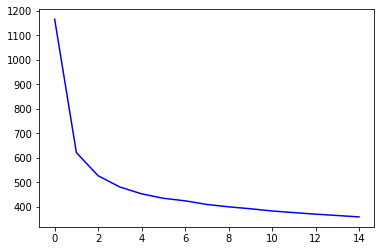

In [9]:
AE_CNN = models.Sequential([enc_cnn, dec_cnn])
AE_CNN.compile(loss = 'mse')
X_cnn = train_images.reshape(-1, 28, 28, 1)
history = AE_CNN.fit(X_cnn, X_cnn, epochs = 15)
plt.plot(history.history['loss'], 'b-')

<Figure size 432x288 with 0 Axes>

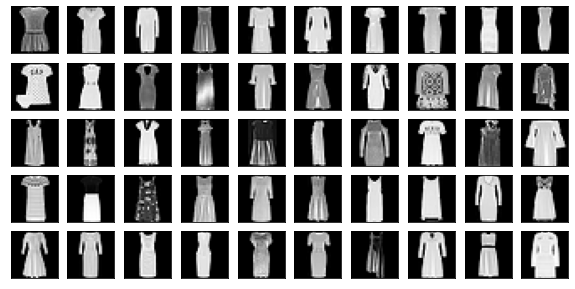

In [10]:
# 드레스만 인코딩하여 잠재표현을 얻자
dress_idx = train_labels == 3    # 드레스의 클래스 번호는 3
dress_array = train_images[dress_idx]
plot_images(5, 10, dress_array.reshape(-1, 28, 28))

(60000, 28, 28)
188/188 [==============================] - 1s 3ms/step


<Figure size 432x288 with 0 Axes>

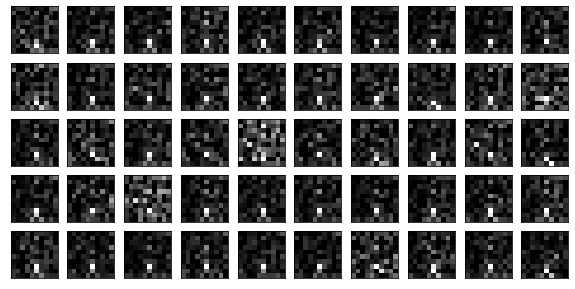

In [11]:
print(train_images.shape)
dress_array = dress_array.reshape(-1,28,28, 1)
dress_encoded = enc_cnn.predict(dress_array)
plot_images(5, 10, dress_encoded.reshape(-1, 10, 10))

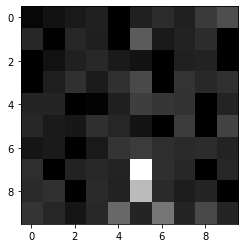

In [12]:
dress_latent = dress_encoded.mean(axis = 0)
plt.imshow(dress_latent.reshape(10,10), cmap='gray')

In [13]:
dress_latent_augmented = []
for _ in range(50):
    # 잠재 표현에 잡음 추가
    new_dress = dress_latent*(1+np.random.randn(100)*0.3)
    dress_latent_augmented.append(new_dress)  # 잡음 추가된 데이터를 리스트화
# 변형된 잠재 표현의 리스트를 넘파이 배열로 바꾼다.
dress_latent_augmented = np.array(dress_latent_augmented)

2/2 [==============================] - 0s 4ms/step


<Figure size 432x288 with 0 Axes>

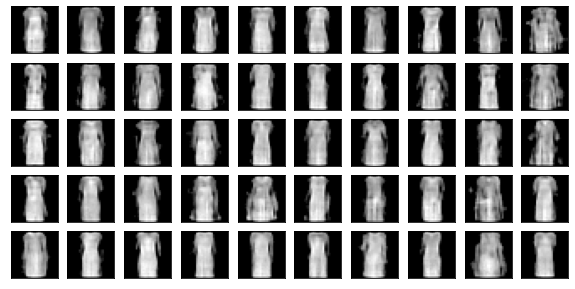

In [14]:
dress_generated = dec_cnn.predict([dress_latent_augmented])
plot_images(5, 10, dress_generated.reshape(-1, 28, 28))

### 12장 미니프로젝트

#### 1. 데이터 확인과 준비

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread             # 이미지를 읽어 들인다
from skimage.transform import resize      # 이미지의 크기를 변경할 수 있다

#### 2. 이미지 읽어 들이기

In [2]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj1/40/'

imgR, imgC, channel = 63, 63, 3
images = []

for i in range(40):
   file = url + 'img{0:02d}.jpg'.format(i+1)    # 이미지 파일 이름을 만든다
   img = imread(file)                           # 이미지를 읽는다
   img = resize(img, (imgR,imgC, channel))      # 이미지의 크기를 변경한다
   images.append(img)                           # img에 담는다

<Figure size 432x288 with 0 Axes>

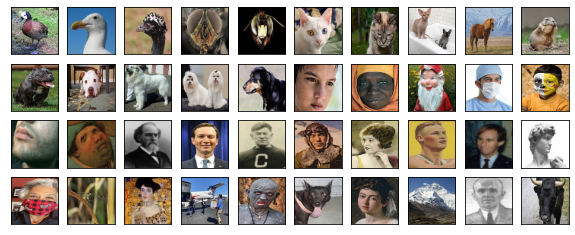

In [3]:
def plot_images(nRow, nCol, img):
   fig = plt.figure()
   fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
   for i in range(nRow):
       for j in range(nCol):
           if nRow <= 1: axis = ax[j]
           else:         axis = ax[i, j]
           axis.get_xaxis().set_visible(False)
           axis.get_yaxis().set_visible(False)
           axis.imshow(img[i*nCol+j])

plot_images(4, 10, images)

#### 3. 훈련용 데이터와 검증용 데이터 분리

<Figure size 432x288 with 0 Axes>

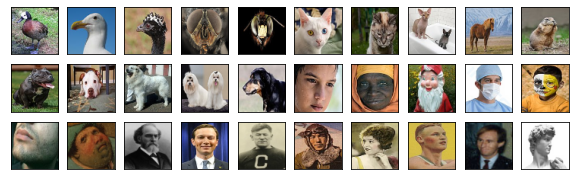

<Figure size 432x288 with 0 Axes>

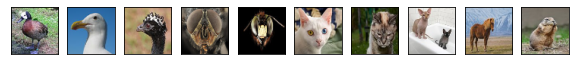

In [4]:
X = np.array(images[:30]) # 앞 30장 이미지 훈련용으로 사용
X_test =np.array(images[30:]) # 나머지 검증용 사용
plot_images(3, 10, X)
plot_images(1, 10, X)

#### 4. 입력 데이터 준비

<Figure size 432x288 with 0 Axes>

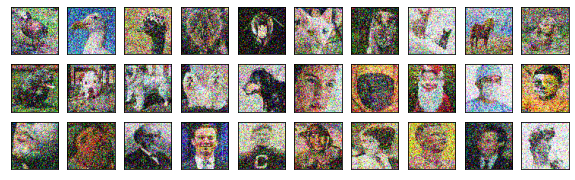

<Figure size 432x288 with 0 Axes>

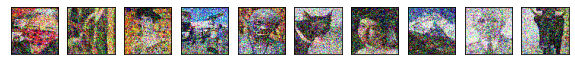

In [5]:
# 30 * 63 * 63 * 3
X_noisy = X + np.random.randn(len(X), imgR, imgC, channel)*0.3
X_noisy = np.clip(X_noisy, 0, 1)

X_test_noisy =  X_test \
             +  np.random.randn(len(X_test), imgR, imgC, channel)*0.3
X_test_noisy = np.clip(X_test_noisy, 0, 1)

plot_images(3, 10, X_noisy)
plot_images(1, 10, X_test_noisy)

#### 5. 오토인코더 만들기

In [6]:
from tensorflow.keras import models
from tensorflow.keras import layers
enc_cnn = models.Sequential([
            layers.Conv2D(filters=16, kernel_size=3, 
                  strides=(3,3), activation='elu', input_shape=(63,63,3)),
            layers.Conv2D(filters=8, kernel_size=3, activation='elu'),
            layers.Flatten(),
            layers.Dense(1024, activation='elu')])
enc_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 21, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 8)         1160      
                                                                 
 flatten (Flatten)           (None, 2888)              0         
                                                                 
 dense (Dense)               (None, 1024)              2958336   
                                                                 
Total params: 2,959,944
Trainable params: 2,959,944
Non-trainable params: 0
_________________________________________________________________


In [7]:
dec_cnn = models.Sequential([
      layers.Dense(2888, input_shape=(1024, ), activation='elu'),
      layers.Reshape(target_shape=(19,19,8)),
      layers.Conv2DTranspose(filters=16, kernel_size=3, activation='elu'),
      layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(3,3),
                             activation='elu')])
dec_cnn.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2888)              2960200   
                                                                 
 reshape (Reshape)           (None, 19, 19, 8)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 21, 21, 16)       1168      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 63, 63, 3)        435       
 ranspose)                                                       
                                                                 
Total params: 2,961,803
Trainable params: 2,961,803
Non-trainable params: 0
_________________________________________________________________


In [8]:
AE_CNN = models.Sequential([enc_cnn, dec_cnn])
AE_CNN.compile(loss = 'mse')
AE_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1024)              2959944   
                                                                 
 sequential_1 (Sequential)   (None, 63, 63, 3)         2961803   
                                                                 
Total params: 5,921,747
Trainable params: 5,921,747
Non-trainable params: 0
_________________________________________________________________


#### 6. 오토인코더 학습시키기

Epoch 1/100
1/1 [==============================] - 1s 511ms/step - loss: 0.2965
Epoch 2/100
1/1 [==============================] - 0s 51ms/step - loss: 0.2833
Epoch 3/100
1/1 [==============================] - 0s 59ms/step - loss: 0.3607
Epoch 4/100
1/1 [==============================] - 0s 48ms/step - loss: 0.4890
Epoch 5/100
1/1 [==============================] - 0s 53ms/step - loss: 0.3665
Epoch 6/100
1/1 [==============================] - 0s 50ms/step - loss: 0.2800
Epoch 7/100
1/1 [==============================] - 0s 50ms/step - loss: 0.2183
Epoch 8/100
1/1 [==============================] - 0s 48ms/step - loss: 0.1954
Epoch 9/100
1/1 [==============================] - 0s 49ms/step - loss: 0.1825
Epoch 10/100
1/1 [==============================] - 0s 57ms/step - loss: 0.1865
Epoch 11/100
1/1 [==============================] - 0s 60ms/step - loss: 0.1515
Epoch 12/100
1/1 [==============================] - 0s 58ms/step - loss: 0.1490
Epoch 13/100
1/1 [==============================

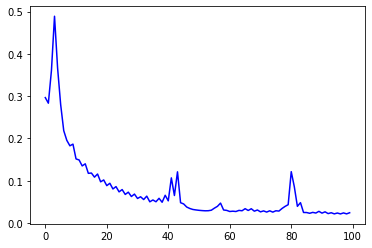

In [9]:
history = AE_CNN.fit(X_noisy, X, epochs = 100)
plt.plot(history.history['loss'], 'b-')

#### 7. 훈련용데이터와 테스트 데이터 잡음 제거

1/1 [==============================] - 0s 87ms/step


<Figure size 432x288 with 0 Axes>

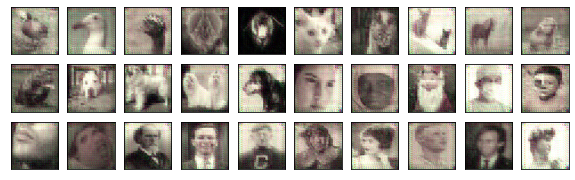

In [10]:
denoised_result = AE_CNN.predict(X_noisy)
denoised_result = np.clip(denoised_result, 0,1)
plot_images(3, 10, denoised_result)

1/1 [==============================] - 0s 20ms/step


<Figure size 432x288 with 0 Axes>

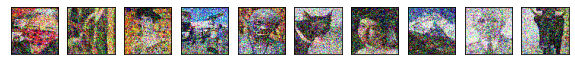

<Figure size 432x288 with 0 Axes>

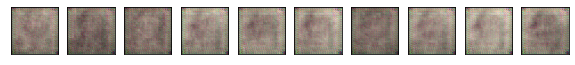

In [11]:
denoised_result = AE_CNN.predict(X_test_noisy)
denoised_result = np.clip(denoised_result, 0,1)
plot_images(1, 10, X_test_noisy)
plot_images(1, 10, denoised_result)

#### 8. 데이터를 증강하여 훈련 효과 높이기

In [12]:
### Label Augmentation ####
from keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    rotation_range=360,
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

In [13]:
y_aug = X.reshape(-1, imgR, imgC, channel)
it = image_generator.flow(y_aug)
nData = y_aug.shape[0]

In [14]:
X_aug = y_aug + np.random.randn(nData, imgR, imgC, channel)*0.3

In [15]:
X_aug = y_aug + np.random.randn(nData, imgR, imgC, channel)*0.3

n_augmentation = 400
for _ in range(n_augmentation):
   new_y = it.next()
   new_X = new_y + np.random.randn(nData, imgR, imgC, channel)*0.3
   y_aug = np.append(y_aug, new_y, axis=0)   
   X_aug = np.append(X_aug, new_X, axis=0)

y_aug = y_aug.reshape(-1, imgR, imgC, channel)
X_aug = X_aug.reshape(-1, imgR, imgC, channel)
print(y_aug.shape)

(12030, 63, 63, 3)


<Figure size 432x288 with 0 Axes>

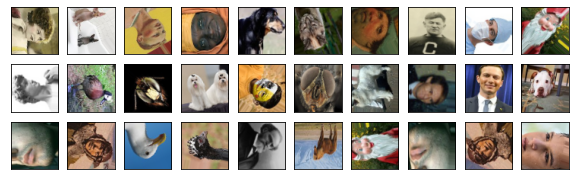

<Figure size 432x288 with 0 Axes>

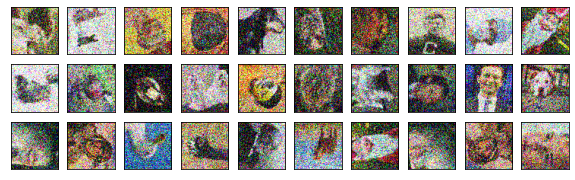

In [16]:
y_aug = np.clip(y_aug, 0, 1)
X_aug = np.clip(X_aug, 0, 1)
start_idx = 157
plot_images(3, 10, y_aug[start_idx: start_idx+30])
plot_images(3, 10, X_aug[start_idx: start_idx+30])

#### 9. 증강 데이터로 학습하고 잡음 제거 실시

Epoch 1/50
376/376 [==============================] - 18s 48ms/step - loss: 0.0343
Epoch 2/50
376/376 [==============================] - 16s 43ms/step - loss: 0.0174
Epoch 3/50
376/376 [==============================] - 16s 43ms/step - loss: 0.0127
Epoch 4/50
376/376 [==============================] - 16s 43ms/step - loss: 0.0108
Epoch 5/50
376/376 [==============================] - 16s 42ms/step - loss: 0.0096
Epoch 6/50
376/376 [==============================] - 16s 43ms/step - loss: 0.0089
Epoch 7/50
376/376 [==============================] - 16s 42ms/step - loss: 0.0083
Epoch 8/50
376/376 [==============================] - 16s 43ms/step - loss: 0.0079
Epoch 9/50
376/376 [==============================] - 16s 42ms/step - loss: 0.0075
Epoch 10/50
376/376 [==============================] - 17s 44ms/step - loss: 0.0073
Epoch 11/50
376/376 [==============================] - 17s 44ms/step - loss: 0.0070
Epoch 12/50
376/376 [==============================] - 17s 45ms/step - loss: 0.0069
E

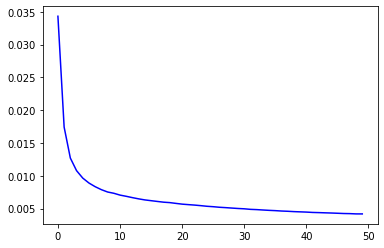

In [17]:
history = AE_CNN.fit(X_aug, y_aug, epochs = 50)
plt.plot(history.history['loss'], 'b-')

376/376 [==============================] - 3s 8ms/step


<Figure size 432x288 with 0 Axes>

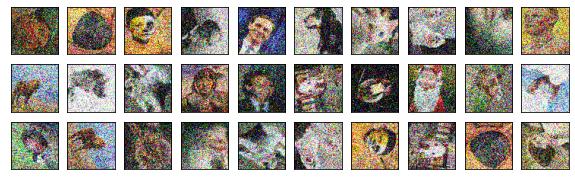

<Figure size 432x288 with 0 Axes>

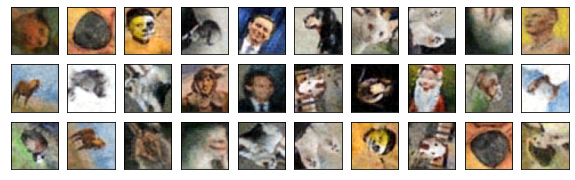

In [18]:
denoised_result = AE_CNN.predict(X_aug)
denoised_result = np.clip(denoised_result, 0, 1)
plot_images(3, 10, X_aug[100:130])
plot_images(3, 10, denoised_result[100:130])

1/1 [==============================] - 0s 16ms/step


<Figure size 432x288 with 0 Axes>

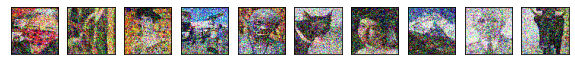

<Figure size 432x288 with 0 Axes>

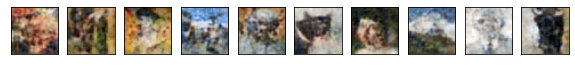

In [19]:
denoised_result = AE_CNN.predict(X_test_noisy)
denoised_result = np.clip(denoised_result, 0, 1)
plot_images(1, 10, X_test_noisy)
plot_images(1, 10, denoised_result)